In [10]:
import keras.src.metrics
import seaborn as sns
from keras.src.metrics import Recall, Precision, F1Score
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
%load_ext autoreload
%autoreload 2
import os

import mlflow
import numpy as np
from dotenv import load_dotenv

from src.functions import create_model, plot_data, check_gpus, create_train_val_datasets, load_stations_from_path, \
    create_test_datasets, plot_keras_history, 
from src.utils import now_formatted, setup_logger, format_with_border, measure_execution_time

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
check_gpus()

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1 Physical GPUs, 1 Logical GPUs


In [12]:
load_dotenv()
mlflow_port = os.getenv('MLFLOW_PORT')
mlflow_uri = f'http://localhost:{mlflow_port}'
mlflow_experiment_name = f'Benchmark'
train_path = '../data/labeled_benchmark/train'
test_path = '../data/labeled_benchmark/test'
log_file_path = '/tmp/benchmark.log'

mlflow.set_tracking_uri(mlflow_uri)
mlflow.set_experiment(mlflow_experiment_name)
# mlflow.tensorflow.autolog()

<Experiment: artifact_location='mlflow-artifacts:/3', creation_time=1700121593486, experiment_id='3', last_update_time=1700121593486, lifecycle_stage='active', name='Benchmark', tags={}>

In [13]:
SEQUENCE_LENGTH = 90
TARGET_START_INDEX = SEQUENCE_LENGTH - 1
FEATURE_COLUMNS = [
    'HS',
    'day_sin',
    'day_cos',
    'month_sin',
    'month_cos',
    'TSS_30MIN_MEAN',
    'TS0_30MIN_MEAN',
    'RSWR_30MIN_MEAN',
    'TA_30MIN_MEAN',
    'VW_30MIN_MEAN'
]
TARGET_COLUMN = 'no_snow'
DATE_COLUMN = 'measure_date'
SPLIT_PERCENTAGE = 0.8
DATASET_BATCH_SIZE = 64

# Model configuration
MODEL_ARCHITECTURE = "128(l)-64-8(d)-1"
MODEL_INPUT_SHAPE = (SEQUENCE_LENGTH, len(FEATURE_COLUMNS))
MODEL_DROPOUT_RATE = 0.5
MODEL_OPTIMIZER = 'adam'
MODEL_METRICS = ['accuracy', Recall(), Precision()],

MODEL_LOSS = 'binary_crossentropy'
MODEL_BATCH_SIZE = 64
MODEL_EPOCHS = 50

def log_parameters(logging, mlflow):
    global_vars = globals()
    for var_name, value in global_vars.items():
        if var_name.isupper():
            logging.info(f'{var_name}: {value}')
            mlflow.log_param(f'benchmark_{var_name.lower()}', value)

In [14]:
training_stations = load_stations_from_path(train_path)
testing_stations = {station.iloc[0]['station_code']: station for station in load_stations_from_path(test_path)}

In [ ]:
for ts in training_stations:
    ts['no_snow'] = ts['no_snow'].astype(int)

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

weights = []

for i, ts in enumerate(training_stations):
    class_weights = compute_class_weight('balanced', classes=np.unique(training_stations[i]['no_snow']), y=training_stations[i]['no_snow'])
    weights.append(class_weights)
    
class_weights = dict(enumerate(np.array(weights).mean(axis=0)))

2023-11-28 21:43:48 INFO 900232456 - <module>: ======================================= Starting experiment =======================================
2023-11-28 21:43:48 INFO 2950040843 - log_parameters: SEQUENCE_LENGTH: 90
2023-11-28 21:43:48 INFO 2950040843 - log_parameters: TARGET_START_INDEX: 89
2023-11-28 21:43:48 INFO 2950040843 - log_parameters: FEATURE_COLUMNS: ['HS', 'day_sin', 'day_cos', 'month_sin', 'month_cos', 'HS', 'TSS_30MIN_MEAN', 'TS0_30MIN_MEAN', 'RSWR_30MIN_MEAN', 'TA_30MIN_MEAN', 'VW_30MIN_MEAN']
2023-11-28 21:43:48 INFO 2950040843 - log_parameters: TARGET_COLUMN: no_snow
2023-11-28 21:43:48 INFO 2950040843 - log_parameters: DATE_COLUMN: measure_date
2023-11-28 21:43:48 INFO 2950040843 - log_parameters: SPLIT_PERCENTAGE: 0.8
2023-11-28 21:43:48 INFO 2950040843 - log_parameters: DATASET_BATCH_SIZE: 64
2023-11-28 21:43:48 INFO 2950040843 - log_parameters: MODEL_ARCHITECTURE: 128(l)-64-8(d)-1
2023-11-28 21:43:48 INFO 2950040843 - log_parameters: MODEL_INPUT_SHAPE: (90, 11

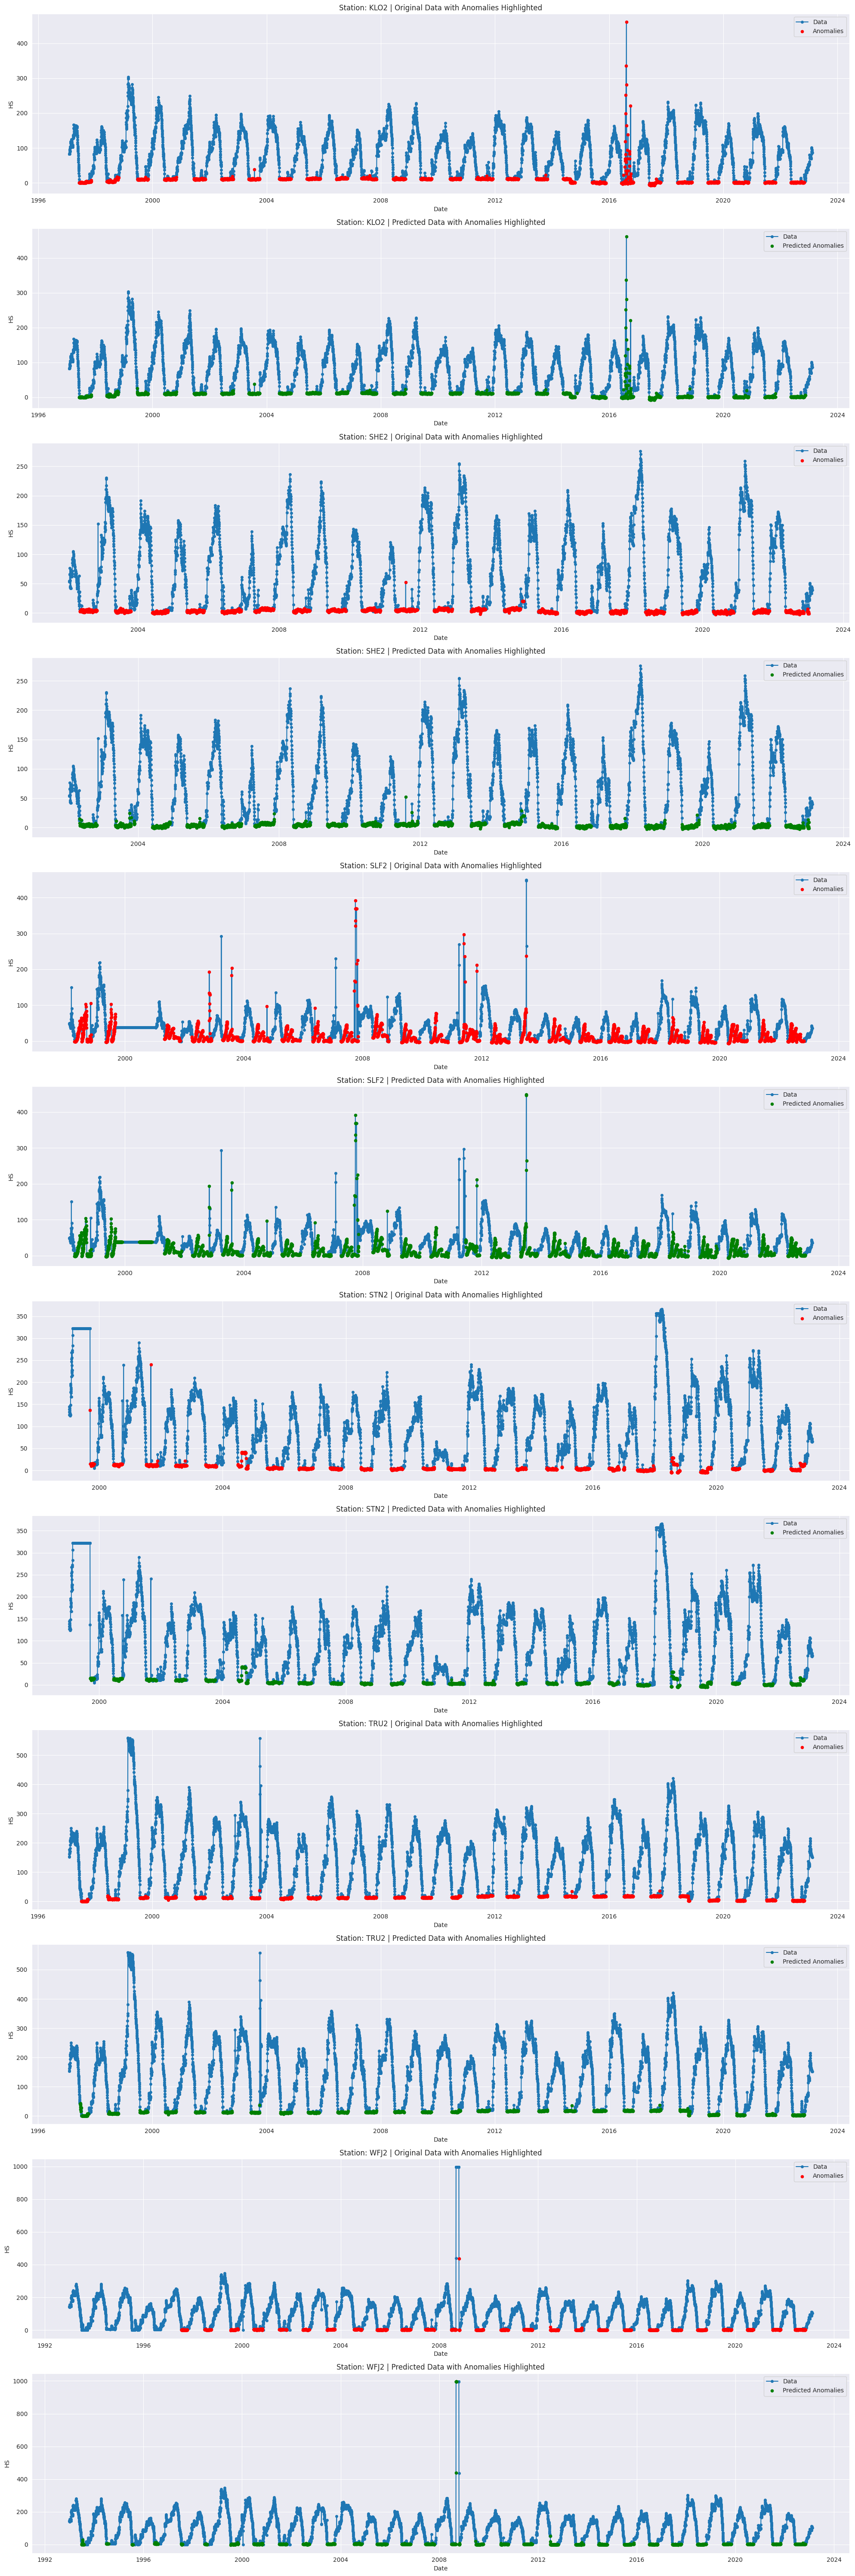

In [15]:
with mlflow.start_run(run_name=now_formatted()):
    logging, tmp_log_file = setup_logger(log_file_path=log_file_path)
    logging.info(format_with_border('Starting experiment'))
    
    log_parameters(logging, mlflow)
    logging.info(format_with_border('Preparing Training Data'))
    train_dataset, val_dataset, mean, std, num_train_samples, num_val_samples, _ = create_train_val_datasets(
        training_stations, SPLIT_PERCENTAGE, FEATURE_COLUMNS, TARGET_COLUMN, SEQUENCE_LENGTH, TARGET_START_INDEX, DATASET_BATCH_SIZE
    )

    logging.info(f"Training samples: {num_train_samples}")
    logging.info(f"Validation samples: {num_val_samples}")
    mlflow.log_param('benchmark_training_samples', num_train_samples)
    mlflow.log_param('benchmark_validation_samples', num_val_samples)

    model = create_model(MODEL_ARCHITECTURE, MODEL_INPUT_SHAPE, logging=None, dropout_rate=MODEL_DROPOUT_RATE, summary=False, dropout_layer='dropout')
    model.compile(
        optimizer=MODEL_OPTIMIZER,
        metrics=MODEL_METRICS,
        loss=MODEL_LOSS
    )
    
    logging.info(format_with_border('Fitting Model'))
    @measure_execution_time
    def fit_model():
        return model.fit(
            train_dataset,
            epochs=MODEL_EPOCHS,
            batch_size=MODEL_BATCH_SIZE,
            validation_data=val_dataset
        )
    history, elapsed_fitting_time = fit_model()
    logging.info(f'Model fitting completed in {elapsed_fitting_time}')
    mlflow.log_param('benchmark_model_fitting_time', elapsed_fitting_time)

    logging.info(format_with_border('Evaluating Model on Test Data'))
    test_datasets = create_test_datasets(
        testing_stations.values(), FEATURE_COLUMNS, TARGET_COLUMN, SEQUENCE_LENGTH, TARGET_START_INDEX, DATASET_BATCH_SIZE, mean, std
    )

    all_evaluation_results = np.empty((0, 5), float)

    for j, dataset in enumerate(test_datasets):
        evaluation_results = model.evaluate(dataset, verbose=0)
        precision = evaluation_results[2]
        recall = evaluation_results[3]
        f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
        station_name = list(testing_stations.keys())[j]
        test_df = list(testing_stations.values())[j]
        logging.info(
            f'Station: {station_name}, Samples: {len(test_df)}, Loss: {evaluation_results[0]:.3f}, Accuracy: {evaluation_results[1]:.3f}, Precision: {precision:.3f}, Recall: {recall:.3f}, F1 Score: {f1_score:.3f}'
        )
        all_evaluation_results = np.append(all_evaluation_results, [evaluation_results + [f1_score]], axis=0)

    mlflow.log_metric('test_avg_loss', np.mean(all_evaluation_results[:, 0]))
    mlflow.log_metric('test_avg_accuracy', np.mean(all_evaluation_results[:, 1]))
    mlflow.log_metric('test_avg_precision', np.mean(all_evaluation_results[:, 2]))
    mlflow.log_metric('test_avg_recall', np.mean(all_evaluation_results[:, 3]))
    mlflow.log_metric('test_avg_f1_score', np.mean(all_evaluation_results[:, 4]))

    predictions = [model.predict(td, verbose=0).reshape((-1,)) > 0.5 for td in test_datasets]
    fig = plot_data(
        [test_station[TARGET_START_INDEX:] for test_station in testing_stations.values()],
        predictions=predictions,
        show=False
    )
    mlflow.log_figure(fig, 'prediction_results.png')
    mlflow.log_artifact(tmp_log_file)

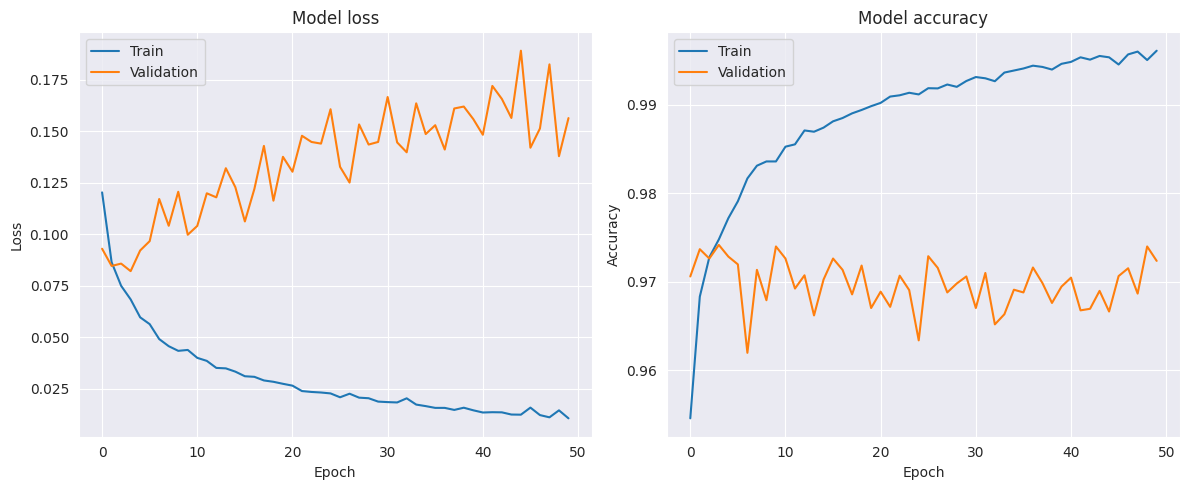

In [16]:
history_plot = plot_keras_history(history)

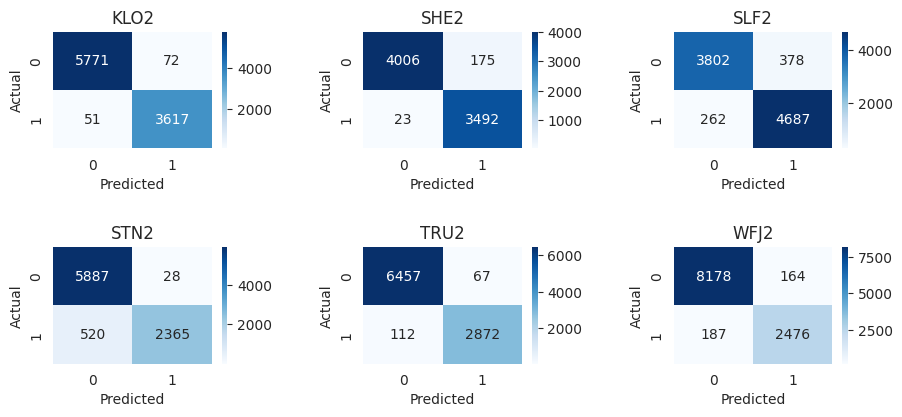

In [17]:
y_true = [ts.loc[TARGET_START_INDEX:, 'no_snow'].values for ts in testing_stations.values()]
y_pred = [model.predict(td, verbose=0).reshape((-1,)) > 0.5 for td in test_datasets]
n_matrices = len(y_true)
n_cols = 3
n_rows = (n_matrices + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 5))
fig.tight_layout(pad=5.0)

for i in range(n_matrices):
    ax = axes[i // n_cols, i % n_cols]
    cm = confusion_matrix(y_true[i], y_pred[i])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(list(testing_stations.keys())[i])
    ax.set_ylabel('Actual')
    ax.set_xlabel('Predicted')

for j in range(i + 1, n_rows * n_cols):
    axes[j // n_cols, j % n_cols].axis('off')

plt.show()